### Evaluate the presence of sample level batch effects by PILOT (Trajectory)

<div class="alert alert-block alert-info">
In this tutorial, we will demonstrate how to use statistical tests to evaluate the potential association between the detected trajectories with any experimental or clinical variable present in a data set. This example will be based on the kidney single cell data.
</div>

In [4]:
import pilotpy as pl
import scanpy as sc
from matplotlib.cm import get_cmap
import seaborn as sns
import pandas as pd

#### Reading the original Anndata:
First, we consider the original kidney single cell data. You can download the Anndata (h5ad) file from [here](https://costalab.ukaachen.de/open_data/PILOT/Kidney_ori.h5ad), and place it in the _Datasets_ folder.

In [ ]:
adata = sc.read_h5ad('/Datasets/kidney_ori.h5ad')

##### Loading the required information and computing the Wasserstein distance:
<div class="alert alert-block alert-info"> In order to work with PILOT, ensure that your Anndata object is loaded and contains the required information.
    
Use the following parameters to configure PILOT for your analysis (Setting Parameters):
    
- adata: Pass your loaded Anndata object to PILOT.
    
- emb_matrix: Provide the name of the variable in the obsm level that holds the dimension reduction (PCA representation).
    
- clusters_col: Specify the name of the column in the observation level of your Anndata that corresponds to cell types or clusters.
    
- sample_col: Indicate the column name in the observation level of your Anndata that contains information about samples or patients.
    
- status: Provide the column name that represents the status or disease (e.g., "control" or "case").
       
</div>

In [ ]:
pl.tl.wasserstein_distance(
    adata,
    emb_matrix = 'X_pca',
    clusters_col = 'cell_type',
    sample_col = 'donor_id',
    status = 'disease'
    )

##### Trajectory estimation:
<div class="alert alert-block alert-info"> 
As a next step, we estimate a diffusion map from the Wasserstein distance
</div>

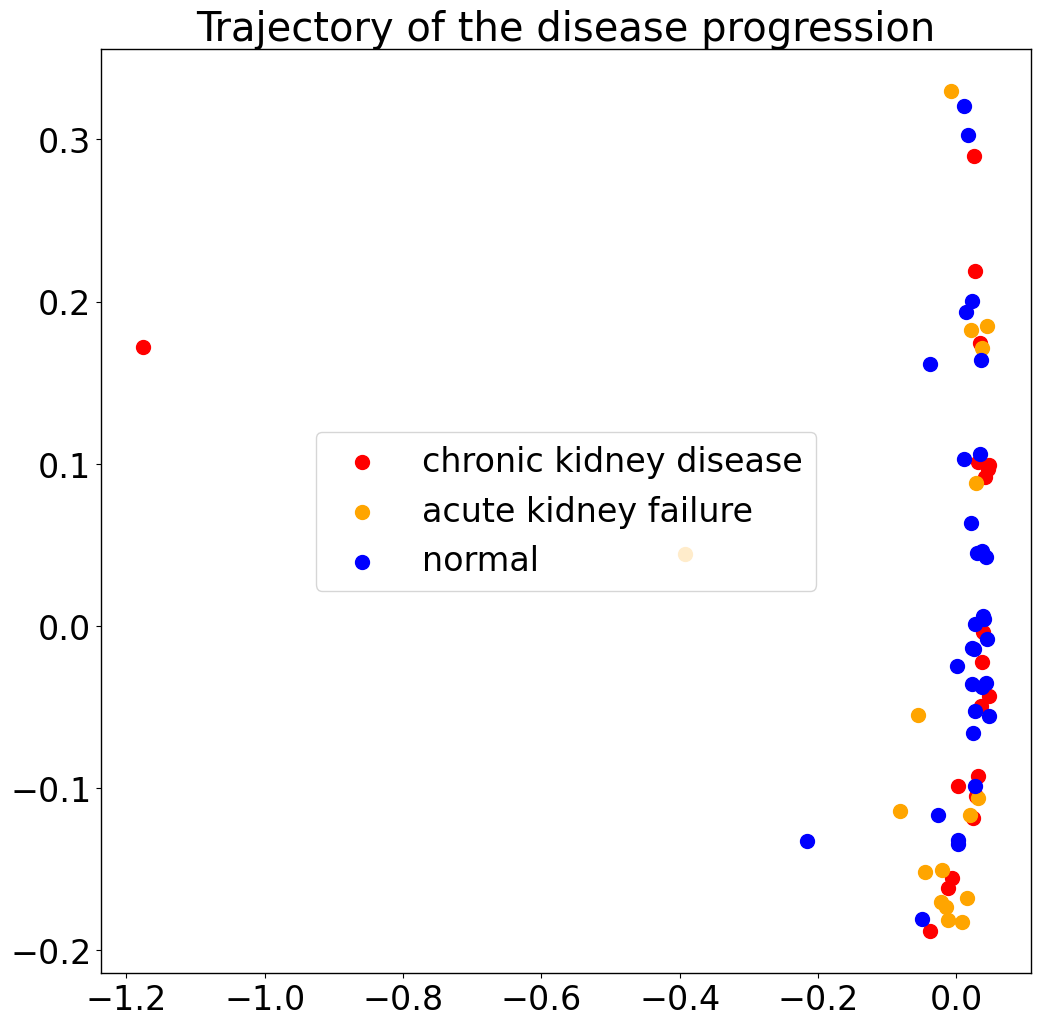

In [7]:
pl.pl.trajectory(adata, colors = ['red','orange','Blue'])

Then estimate the trajectory by fitting a principle graph and calculate the order of samples by 'cell_importance' functions. See main [tutorial](https://pilot.readthedocs.io/en/latest/Myocardial_infarction.html), for details. 

In [9]:
pl.pl.fit_pricipla_graph(adata, source_node = 8)
pl.tl.cell_importance(adata,heatmap_w = 20,height = 15,xlim = 30)

##### Evaluation of the association of estimated disease progression with experimental factor:
A very important question is if PILOT analysis is affected by experimental artefacts (location of tissues, batch processing). To evaluate this, we use ANOVA statistics and Spearman correlation to check any association between any variables describing the disease cohort and the predicted variables. 

To run these functions, provide the sample_col as the Sample/Patient column and your interested variables. Of note, these functions only show the significant variables (p-value < 0.05).

In [10]:
numeric = ['degen.score','aStr.score','aEpi.score','matrisome.score','collagen.score','glycoprotein.score','proteoglycan.score']

In [11]:
categorical = ['BMI','hypertension','development_stage','sex','eGFR','diabetes_history','disease','tissue']

##### Categorical variables 

In [12]:
pl.tl.correlation_categorical_with_trajectory(adata, sample_col = 'donor_id', features = categorical)

,Feature,ANOVA_FStatistic,ANOVA_PValue
7,tissue,9.772883,0.000022
5,diabetes_history,3.429356,0.038475


#####  Numerical variables : 


Similarly, you can do the same analysis for numerical variables. 

In [13]:
pl.tl.correlation_numeric_with_trajectory(adata, sample_col = 'donor_id', features = numeric)

,Feature,Spearman_Correlation,Spearman_PValue
0,degen.score,0.262272,0.032027


We observe that there is a clear association between the trajectory and the origin of the biopsies. This is not surprising as PILOT uses cellular composition information, as samples at distinct regions do have distinct cells. Regarding continuous variable, we find an association with the degen.score, which is a gene signature score estimated from the comparisons of controls and disease samples (see data manuscript for more details https://doi.org/10.1038/s41586-023-05769-3). 

To double check these results, one can of course plot the trajectory by showing the location as labels. 

###### Tissue

In [14]:
palette = sns.color_palette("husl", len(adata.obs['tissue'].unique()))
colors = [palette[i] for i in range(len(adata.obs['tissue'].unique()))]
pl.tl.wasserstein_distance(
    adata,
    emb_matrix = 'X_pca',
    clusters_col = 'cell_type',
    sample_col = 'donor_id',
    status = 'tissue'
    )

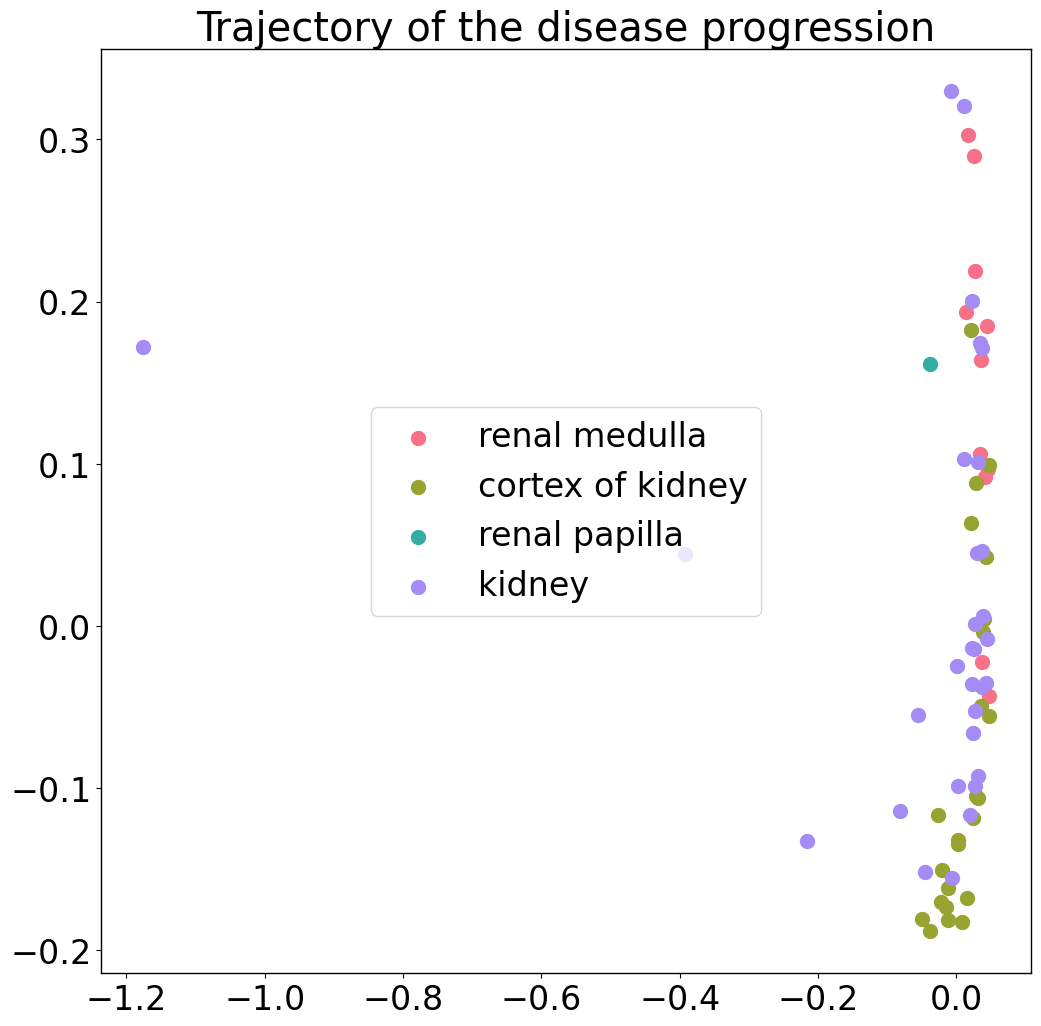

In [15]:
pl.pl.trajectory(adata, colors = colors)

#### Filtering of samples

We focus therefore only on biopsies from sample locationn 'kidney', which were used in our benchmarking. You can download the Anndata (h5ad) file from [here](https://costalab.ukaachen.de/open_data/PILOT/Kidney_filtered.h5ad), and place it in the _Datasets_ folder.

In [16]:
adata_filtered=sc.read_h5ad('/Datasets/Kidney.h5ad')

In [17]:
pl.tl.wasserstein_distance(
    adata_filtered,
    emb_matrix  ='X_pca',
    clusters_col='cell_type',
    sample_col='donor_id',
    status='disease'
    )

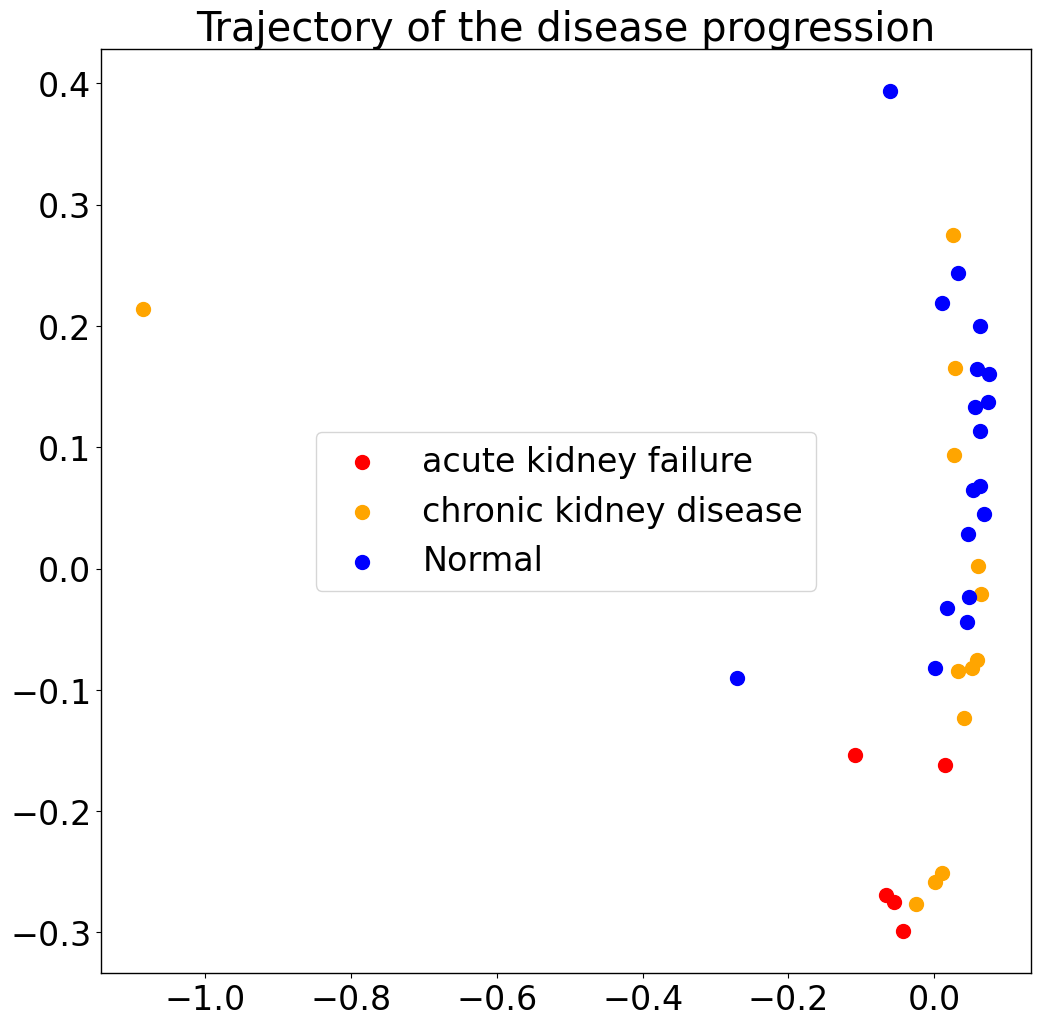

In [18]:
pl.pl.trajectory(adata_filtered, colors = ['red','orange','Blue'])

##### Categorical variables 

We next recheck the association of variables with the estimated trajectory. 

In [23]:
pl.tl.correlation_categorical_with_trajectory(adata_filtered, sample_col='donor_id', features=['BMI','hypertension','development_stage','sex','eGFR','diabetes_history','disease'])

,Feature,ANOVA_FStatistic,ANOVA_PValue
6,disease,9.457675,0.000566
5,diabetes_history,12.517843,0.001189
0,BMI,3.969681,0.016358


In the data we observed that  the true label (disease) has highest association followed by BMI or Diabetes History. While the latter are two clinical factors with a impact on kidney disease, as closer investigation of the variables indicates these association as spurious, as only controls have BMI values and most disease are diabetic. 

##### Diabetes_history

In [24]:
contingency_table = pd.crosstab(adata_filtered.obs['disease'], adata_filtered.obs['diabetes_history'],values=adata_filtered.obs['donor_id'], aggfunc=pd.Series.nunique, margins=True, margins_name='Total Unique Patients')
contingency_table

diabetes_history,No,Yes,Total Unique Patients
disease,,,
Normal,18.0,NaN,18
acute kidney failure,NaN,5.0,5
chronic kidney disease,NaN,13.0,13
Total Unique Patients,18.0,18.0,36


##### BMI

In [25]:
contingency_table = pd.crosstab(adata_filtered.obs['disease'], adata_filtered.obs['BMI'],values=adata_filtered.obs['donor_id'], aggfunc=pd.Series.nunique, margins=True, margins_name='Total Unique Patients')
contingency_table

BMI,18.5—24.9,25.0—29.9,30.0 and Above,unknown,Total Unique Patients
disease,,,,,
Normal,2.0,11.0,4.0,1.0,18
acute kidney failure,NaN,NaN,NaN,5.0,5
chronic kidney disease,NaN,NaN,NaN,13.0,13
Total Unique Patients,2.0,11.0,4.0,19.0,36
